<a href="https://colab.research.google.com/github/TJSun009/University-Projects/blob/main/Chord_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chord Classifier

## Import fastai and timm Libraries

In [ ]:
!pip install -Uqqq timm fastai
import timm
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.8 MB/s eta 0:00:00


## Image Representation

#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import librosa
import librosa.display
from pathlib import Path

#### Waveform

In [ ]:

# always limit two second sample
def save_waveform(audio_file, dest=''):
    samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

    librosa.display.waveshow(samples, sr=sample_rate)
    
    plt.axis('off')

    path = f"{(dest if dest else audio_file).replace('.wav', '_wave.png')}"
    plt.savefig(path)
    plt.close()
    return path


In [ ]:

def save_mel_spectrogram(audio_file, dest=''):
    # Adapted from https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

    samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

    # std spectogram
    sgram = librosa.stft(samples)

    # use the mel-scale instead of raw frequency
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    
    # use the decibel scale to get the final Mel Spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sample_rate)
    
    plt.axis('off')

    path = f"{(dest if dest else audio_file).replace('.wav', '_spec.png')}"
    plt.savefig(path)
    plt.close()
    return path


In [ ]:
def hps(signal, orig_sr, M = 3):
  # harmoic power spectrum of signal
  # M is number of harmonics to be considered
  # notes
  # each index in the array of signal represents a frequency
  # the value in each is amplitude

  decimated_ys = []

  for i in range(0, M + 1):
    y = librosa.resample(signal, orig_sr=orig_sr, target_sr=(2**i)*orig_sr)
    decimated_ys.append(np.abs(y))
  
  min_length = min([len(a) for a in decimated_ys])

  decimated_ys = [a[:min_length] for a in decimated_ys]
  
  hps = np.prod(decimated_ys, axis = 0)

  peak = np.argmax(hps)

  f0 = hps[peak]

  return hps



In [ ]:
def save_chromagram(audio_file, dest = '', type="stft"):
  samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

  if type == "stft":
    chroma = librosa.feature.chroma_stft(samples)
  elif type == "cqt":
    # looks best at first glance
    chroma = librosa.feature.chroma_cqt(samples)
  elif type == "epcp":
    # params from K Lee
    # sample rate - 11025Hz
    # bins - 36, librosa default
    # window length - 8192
    # hop size - 1024
    # note we are using STFT instead of DFT

    samples, sample_rate = librosa.load(audio_file, duration=2, sr=11025)
    samples = hps(samples, sample_rate)

    chroma = librosa.feature.chroma_cqt(samples, hop_length=1024)

  librosa.display.specshow(chroma, sr=sample_rate, y_axis='chroma', x_axis='time')
  
  plt.axis('off')

  plt.show()

  path = f"{(dest if dest else audio_file).replace('.wav', f'_chroma_{type}.png')}"
  # plt.savefig(path)
  # plt.close()
  return path

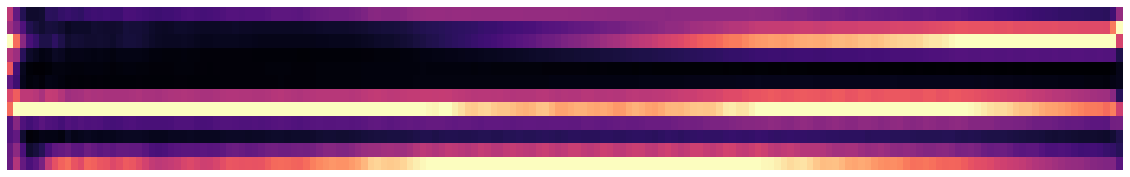

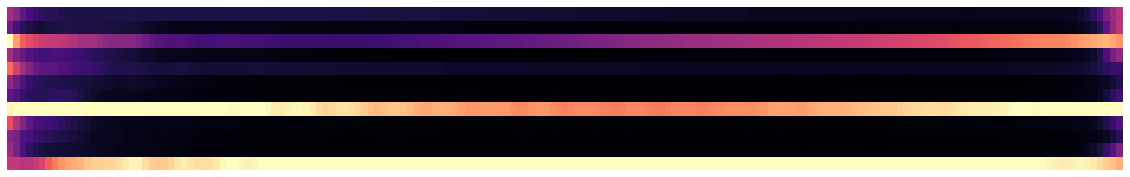

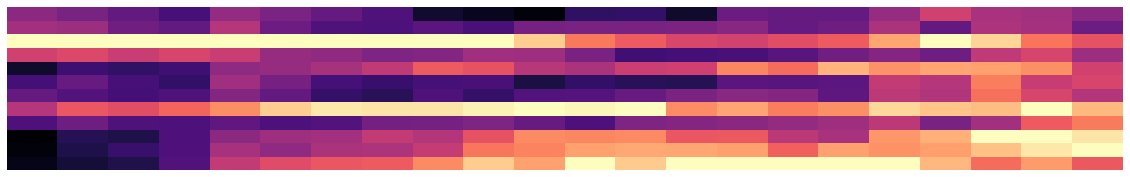

'/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/piano_triads/A_min_4_1_chroma_epcp.png'

In [ ]:
save_chromagram("/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/piano_triads/A_min_4_1.wav")
save_chromagram("/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/piano_triads/A_min_4_1.wav", type="cqt")
save_chromagram("/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/piano_triads/A_min_4_1.wav", type="epcp")

## Data Retrieval

### Transform Audio File to Image
<font color='red'>*Only run when new data required</font>


#### Retrieve Major, Minor Chord Dataset from Kaggle

In [ ]:
# Install Kaggle CLI and setup API Key
! pip install kaggle -Uqqq
! mkdir -p ~/.kaggle/
! cp "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/kaggle.json" ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# Download and Unzip Audio Files from Dataset
!(if [ ! -d "/content/Audio_Files" ]; then \
  kaggle datasets download -d deepcontractor/musical-instrument-chord-classification; \
  unzip -qn musical-instrument-chord-classification; \
  rm musical-instrument-chord-classification.zip; \
fi)

# Create Directories for Generated Images
!(if [ ! -d "/content/Images" ]; then \
  mkdir -p /content/Images; \
  mkdir -p /content/Images/Spectrogram/Minor; \
  mkdir -p /content/Images/Spectrogram/Major; \
  mkdir -p /content/Images/Waveform/Minor; \
  mkdir -p /content/Images/Waveform/Major; \
fi)

 98% 133M/135M [00:05<00:00, 29.9MB/s]
100% 135M/135M [00:05<00:00, 25.4MB/s]


#### Do Transform



*   Spectrogram
*   Waveform



In [ ]:
from pathlib import Path

for i in ['Minor', 'Major']:
  
  directory = f"/content/Audio_Files/{i}"

  for file in Path(directory).glob('*'):
    save_mel_spectrogram(str(file), f"/content/Images/Spectrogram/{i}/{file.name}")
    save_waveform(str(file), f"/content/Images/Waveform/{i}/{file.name}")
    file.unlink()

!rm -r /content/Audio_Files

## Image Setup

In [ ]:
IMAGE_ROOT = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1"

In [ ]:
!cp -r "/content/Images" "{IMAGE_ROOT}"

## Remove Invalid Images

In [ ]:
invalid = 0

for i in ['Spectrogram', 'Waveform']:
  for j in ['Minor', 'Major']:

    failed = verify_images(get_image_files(f"{IMAGE_ROOT}/Images/{i}/{j}"))
    failed.map(Path.unlink)
    invalid += len(failed)

invalid

0

## Neptune Ai Integration

In [ ]:
! pip install -Uqqq "neptune-client[fastai]"

In [ ]:
import neptune.new as neptune

run = neptune.init_run(
    project="tjsun009/chord-classifier",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzkxMzQ2OS01YmE5LTQ2NTAtYWMzZS1lZTI4YmQ0NWMwY2UifQ==",
)

## Create ChordLearner Class

In [ ]:
class ChordLearner():
  def __init__(self, type, model = "convnext_small_in22k", valid_pct = 0.2, seed = 42, run = None, bs = 32):
    self.type = type
    self.model = model
    self.valid_pct = valid_pct
    self.seed = seed
    self.batch_size = bs
    self.run = run
    self.data_loader = None
    self.learner = None

    self.img_types = [
        ["spectogram", "spec", "s"],
        ["waveform", "wave", "w"],
        ["stft_chromagram", "stft", "sc"],
        ["cqt_chromagram","cqt", "cc"],
        ["epcp_chromagram", "epcp", "ec"]
    ]

    self.run["chord_learner/params"] = {
        "type" : self.type,
        "model" : self.mode,
        "valid_pct" : self.valid_pct, 
        "seed" : self.seed
    }
  
  def get_data_loader(self):
    for types in self.img_types:
      if self.type in types:
        self.data_loader = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed),
            get_y=parent_label,
            item_tfms=[Resize(192, method='squish')]
        ).dataloaders(f"{IMAGE_ROOT}/images/{types[0]}/", bs=self.batch_size)

        self.type = types[1]

        return self.data_loader
    else:
      raise TypeError("Not a valid Type")

  def get_utc_timestamp():
    from datetime import datetime, timezone
    dt = datetime.now(timezone.utc)
      
    utc_time = dt.replace(tzinfo=timezone.utc)
    utc_timestamp = utc_time.timestamp()
    utc_timestamp

    return str(round(utc_timestamp))

  def train(self, epochs=5, metrics=BalancedAccuracy(), plot_local=True):
    if self.data_loader == None:
      self.get_data_loader()

    from neptune.new.integrations.fastai import NeptuneCallback

    neptune_callback = NeptuneCallback(run=self.run)
    
    self.learner = vision_learner(self.data_loader, self.model, metrics=metrics, cbs=neptune_callback)

    if plot_local:
      self.learner.recorder.plot_losses()

  def new_pred(self, epochs=5, samples=None, new_pred_path=None):
    if new_pred_path:
      learner = self.learner

      loader = DataBlock(
          blocks=(ImageBlock, CategoryBlock),
          get_items=get_image_files,
          splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed),
          get_y=parent_label,
          item_tfms=[Resize(192, method='squish')]
      ).dataloaders(f"{new_pred_path}/", bs=self.batch_size)

      learner.dls = loader

      learner.fine_tune(epochs)

      return Interpretation.from_learner(learner, dl=loader)
    elif samples:
      
  
  def get_interpretation(self):
    return Interpretation.from_learner(self.learner, dl=self.data_loader)

  def save_model(self, dest_path=None):
    if dest_path:
      if self.learner:
        timestamp = self.get_utc_timestamp()
        self.learner.export(Path(dest_path)/f"model_{self.type}_{timestamp}.pkl")
      else:
        raise TypeError("The Learner has not been initialised. Do this via the train function.")
    else:
      raise TypeError("Destination path is not set.")


## Train the Model
Model A\
Use `DataLoader` and `DataBlock` to train model

### Spectrograms

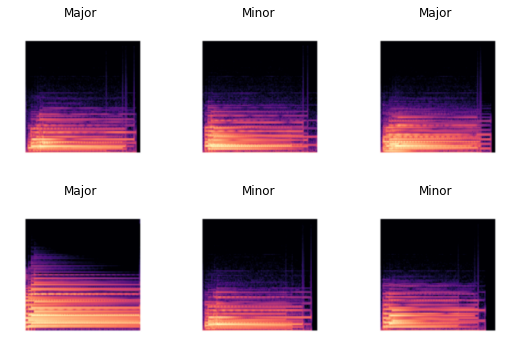

In [ ]:
specs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{IMAGE_ROOT}/Images/Spectrogram/", bs=32)

specs.show_batch(max_n=6)

### Waveforms

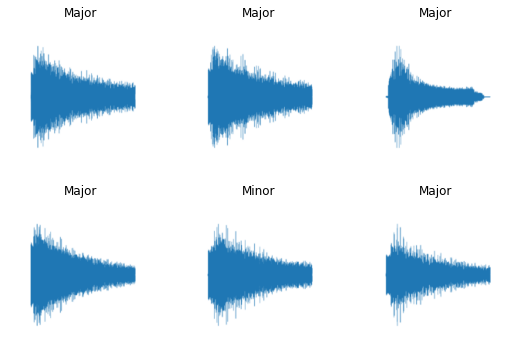

In [ ]:
waves = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{IMAGE_ROOT}/Images/Waveform/", bs=32)

waves.show_batch(max_n=6)

Use Convnext to Train on Images

In [ ]:
timm.list_models("convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
wave_learner = vision_learner(waves, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner = vision_learner(specs, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner.fine_tune(5)
wave_learner.fine_tune(5)

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.206480,1.423196,0.498520,00:12


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.874439,0.676441,0.668837,00:22
1,0.782592,0.664473,0.658257,00:22
2,0.703303,0.470432,0.773528,00:22
3,0.599771,0.477066,0.775747,00:23
4,0.511921,0.433614,0.806748,00:23


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.183381,1.064115,0.548165,00:13


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.833110,0.735793,0.645753,00:23
1,0.789874,0.720524,0.613643,00:23
2,0.714555,0.588316,0.695102,00:22
3,0.628818,0.567670,0.720553,00:22
4,0.538245,0.549751,0.712489,00:22


## Export Model

In [ ]:
def export_models(model_name, wave_learner, spec_learner):
  wave_learner.export(fname=f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/export_wave_{model_name}.pkl")
  spec_learner.export(fname=f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/export_spec_{model_name}.pkl")
  path = Path(f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/")
  path.ls(file_exts='.pkl')

## Test Model on New Data

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1"
spec_learner = load_learner(f"{MODEL_DIR}/export_spec.pkl")
wave_learner = load_learner(f"{MODEL_DIR}/export_wave.pkl")

In [ ]:
def get_ensemble_pred(spec, wave):
  spec_probs = spec_learner.predict(spec)[2].numpy()
  wave_probs = wave_learner.predict(wave)[2].numpy()
  probs = np.mean([spec_probs, wave_probs], axis = 0)

  return ('Major', 0, probs) if probs[0] > probs[1] else ('Minor', 1, probs)

In [ ]:
def test_pred(file, dest, true_label):
  spec_path = save_mel_spectrogram(str(file), f"{dest}/Images/Spectrogram/{true_label}/{file.name}")
  wave_path = save_waveform(str(file), f"{dest}/Images/Waveform/{true_label}/{file.name}")

  spec, wave = PILImage.create(spec_path), PILImage.create(wave_path)

  result = get_ensemble_pred(spec, wave)

  # comparing label to prediction
  
  # positive is major, negative is minor
  if result[0].lower() == "major":
    return "TP" if true_label.lower() == "major" else "FP"
  else:
    return "TN" if true_label.lower() == "minor" else "FN"

In [ ]:
from glob import iglob
from tqdm.notebook import tqdm

TEST_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests"

In [ ]:
def do_test_piano_triads():

  # Dataset available at https://www.kaggle.com/datasets/davidbroberts/piano-triads-wavset
  DATASET = "piano_triads"
  
  files = list(iglob(f"{TEST_DIR}/{DATASET}/*_maj_*.wav")) + list(iglob(f"{TEST_DIR}/{DATASET}/*_min_*.wav"))

  bs_dict = {
      "TP": 0,
      "FP": 0,
      "TN": 0,
      "FN": 0,
  }

  for file in tqdm(files):
    
    label = "major" if file.find("maj") != -1 else "minor"

    file = Path(file)
    
    obs = test_pred(file, TEST_DIR, label)

    bs_dict[obs] += 1

  sensitivity = bs_dict["TP"] / (bs_dict["TP"] + bs_dict["FN"])
  specificity = bs_dict["TN"] / (bs_dict["TN"] + bs_dict["FP"])

  
  accuracy = (bs_dict["TP"] + bs_dict["TN"])/len(files) 
  balanced_accuracy = (sensitivity + specificity)/2

  print(f"Accuracy: {accuracy}")
  print(f"Balanced Accuracy: {balanced_accuracy}")

In [ ]:
do_test_piano_triads()

  0%|          | 0/288 [00:00<?, ?it/s]

Accuracy: 0.5034722222222222
Balanced Accuracy: 0.5034722222222222


## Retrain Model on New Data
Model B

In [ ]:
specs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{TEST_DIR}/Images/Spectrogram/", bs=32)

waves = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{TEST_DIR}/Images/Waveform/", bs=32)

wave_learner = vision_learner(waves, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner = vision_learner(specs, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner.fine_tune(5)
wave_learner.fine_tune(5)

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.545441,1.145424,0.490764,00:09


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.098240,1.116466,0.504926,00:07
1,0.940801,1.332871,0.472906,00:07
2,0.861636,1.099235,0.509852,00:07
3,0.787804,1.185981,0.457512,00:07
4,0.707076,1.212473,0.474754,00:07


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.380859,1.972611,0.500616,00:04


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.004729,0.935897,0.436576,00:07
1,0.925631,0.702593,0.664409,00:08
2,0.843441,0.813344,0.580665,00:08
3,0.755619,0.801054,0.578818,00:08
4,0.717281,0.787455,0.579433,00:08


In [ ]:
export_models("model_b", wave_learner, spec_learner)

# Test New Model on Old Data

In [ ]:
TEST_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Images"

def do_test_musical_instrument_chord_classification():

  def test_pred(spec_path, wave_path, true_label):
    spec, wave = PILImage.create(spec_path), PILImage.create(wave_path)

    result = get_ensemble_pred(spec, wave)
    # return ('Major', 0, probs) if probs[0] > probs[1] else ('Minor', 1, probs)

    # comparing label to prediction
    
    # positive is major, negative is minor
    if result[0].lower() == "major":
      return "TP" if true_label.lower() == "major" else "FP"
    else:
      return "TN" if true_label.lower() == "minor" else "FN"

  spec_files = list(iglob(f"{TEST_DIR}/Spectrogram/**/*.png"))

  bs_dict = {
      "TP": 0,
      "FP": 0,
      "TN": 0,
      "FN": 0,
  }

  for spec_file in tqdm(spec_files):
    
    label = "major" if spec_file.lower().find("maj") != -1 else "minor"

    wave_file = spec_file.replace(f"/Spectrogram/", "/Waveform/").replace("_spec.png", "_wave.png")

    obs = test_pred(spec_file, wave_file, label)

    bs_dict[obs] += 1

  sensitivity = bs_dict["TP"] / (bs_dict["TP"] + bs_dict["FN"])
  specificity = bs_dict["TN"] / (bs_dict["TN"] + bs_dict["FP"])

  
  accuracy = (bs_dict["TP"] + bs_dict["TN"])/len(spec_files)
  balanced_accuracy = (sensitivity + specificity)/2

  print(f"Accuracy: {accuracy}")
  print(f"Balanced Accuracy: {balanced_accuracy}")

In [ ]:
do_test_musical_instrument_chord_classification()
# Does really badly predicting negativpositive cases in the other set

  0%|          | 0/859 [00:00<?, ?it/s]

Accuracy: 0.580908032596042
Balanced Accuracy: 0.49943921791824303


In [ ]:
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/major"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/minor"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/major"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/minor"

In [ ]:
dirs = ["/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/Images", "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Images"]

types = ["major", "minor"]

for dir in dirs:
  for t in types:
    ! cp -r "{dir}/Spectrogram/{t}/." "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/{t}"
    ! cp -r "{dir}/Waveform/{t}/." "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/{t}"

In [ ]:
# Clean Env

# !rm -r /content/Audio_Files
# !rm -r /content/Images

# Joint Training#
Model C

In [ ]:
JOINT_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images"

epochs = 5

specs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{JOINT_DIR}/spectrogram/", bs=32)

waves = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{JOINT_DIR}/waveform/", bs=32)

wave_learner = vision_learner(waves, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner = vision_learner(specs, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner.fine_tune(epochs)
wave_learner.fine_tune(epochs)

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.215849,0.927803,0.605370,00:18


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.919559,0.787091,0.632105,00:30
1,0.909991,1.114704,0.585683,00:29
2,0.835629,0.648779,0.681937,00:29
3,0.721952,0.626523,0.727593,00:29
4,0.621450,0.639259,0.726444,00:29


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.279205,0.974863,0.646277,00:17


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.939979,0.787415,0.590777,00:29
1,0.906607,0.908084,0.600046,00:29
2,0.822325,0.754828,0.695534,00:30
3,0.740319,0.656278,0.676115,00:30
4,0.678142,0.628854,0.691934,00:29


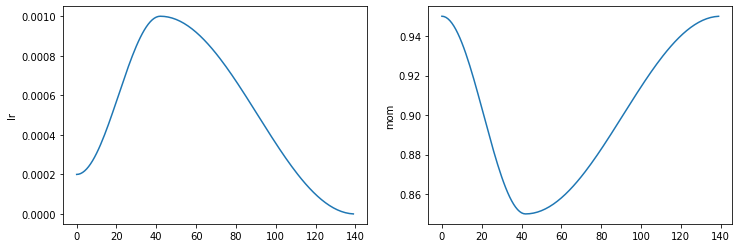

In [ ]:
wave_learner.recorder.plot_sched()

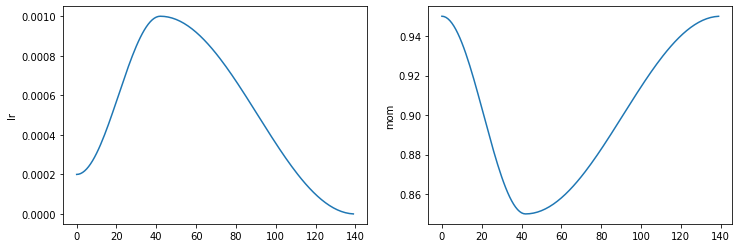

In [ ]:
spec_learner.recorder.plot_sched()